In [158]:
import yfinance  as yf
from pathlib import Path
from pypfopt import EfficientFrontier, objective_functions
from pypfopt import risk_models
from pypfopt import expected_returns
import quantstats as qs

In [159]:
start_date, end_train_date, end_date = "2019-01-01", "2021-12-31", "2023-12-31"

In [160]:
symbols = Path("data/outputs/kmeans-portfolio.csv").read_text().split("\n")
df = yf.download(symbols, start=start_date, end=end_date)["Adj Close"]

[*********************100%%**********************]  10 of 10 completed


In [161]:
df_train = df.loc[start_date:end_train_date]
df_test = df.loc[end_train_date:end_date]

In [162]:
# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
ef.add_objective(objective_functions.L2_reg, gamma=1)

raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

ef.portfolio_performance(verbose=True)

Expected annual return: 22.0%
Annual volatility: 26.6%
Sharpe Ratio: 0.75


/Users/gw/workspace/quant-studies/venv/lib/python3.9/site-packages/pypfopt/expected_returns.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna(how="all")
/Users/gw/workspace/quant-studies/venv/lib/python3.9/site-packages/pypfopt/expected_returns.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna(how="all")
/Users/gw/workspace/quant-studies/venv/lib/python3.9/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may 

(0.21959332915000887, 0.26560726518916206, 0.7514603525918656)

[*********************100%%**********************]  1 of 1 completed


/Users/gw/workspace/quant-studies/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/gw/workspace/quant-studies/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/gw/workspace/quant-studies/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2019-01-04   2019-01-04
End Period                 2021-12-30   2021-12-30
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          14.48%       64.51%
CAGR﹪                     3.17%        12.18%

Sharpe                     0.31         0.74
Prob. Sharpe Ratio         69.78%       88.91%
Smart Sharpe               0.25         0.61
Sortino                    0.41         0.99
Smart Sortino              0.33         0.81
Sortino/√2                 0.29         0.7
Smart Sortino/√2           0.24         0.58
Omega                      1.16         1.16

Max Drawdown               -46.82%      -44.09%
Longest DD Days            348          308
Volatility (ann.)          30.27%       28.64%
R^2                        0.89         0.89
Information Ratio          0.07         0.07
Calmar              

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-01-24,2020-03-23,2020-11-26,308,-44.085950,-39.677690
2,2021-06-08,2021-11-04,2021-12-30,206,-13.521808,-12.705515
3,2021-01-11,2021-03-01,2021-04-07,87,-11.372035,-10.790939
4,2019-03-19,2019-05-16,2019-06-19,93,-10.197042,-9.901757
5,2019-07-19,2019-08-26,2019-09-11,55,-7.347453,-6.775185


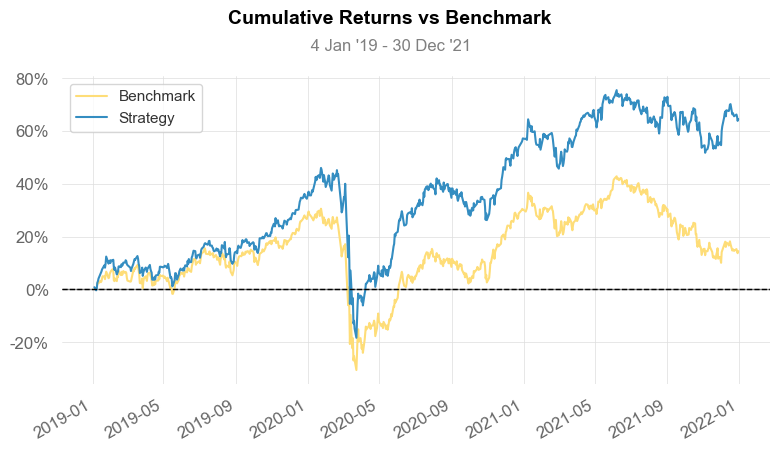

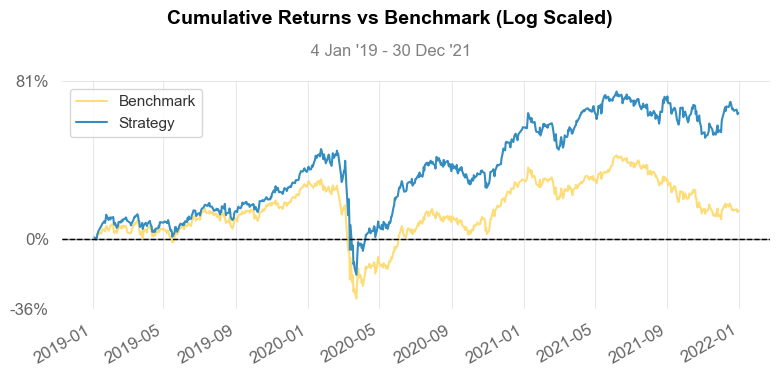

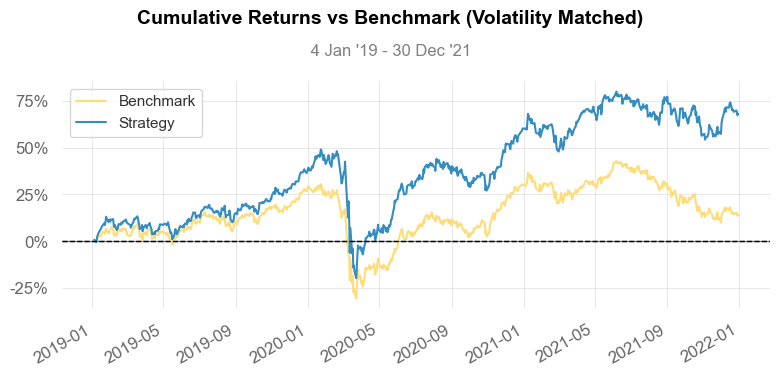

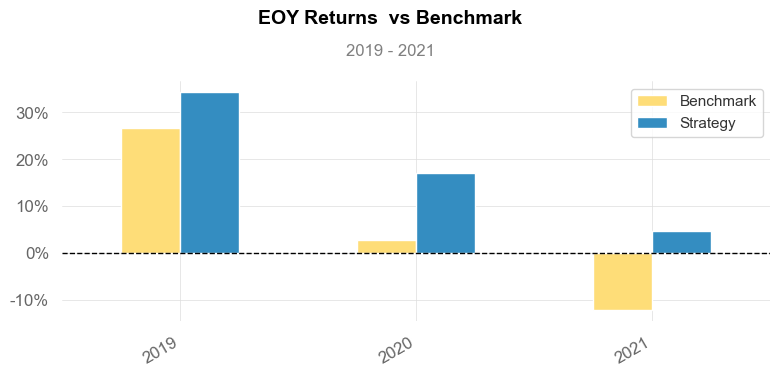

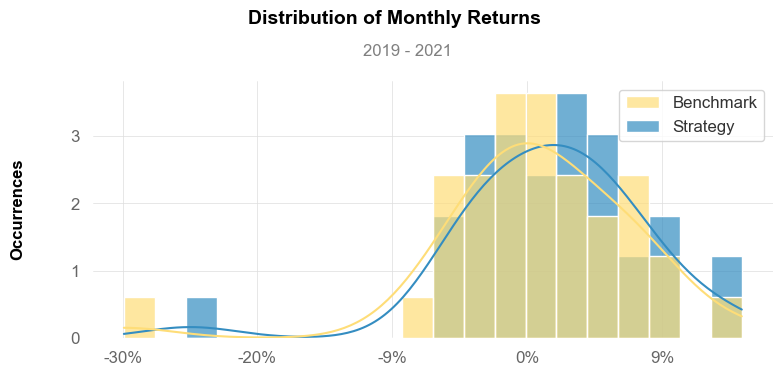

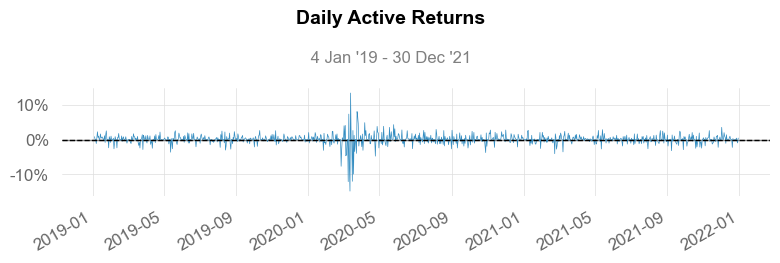

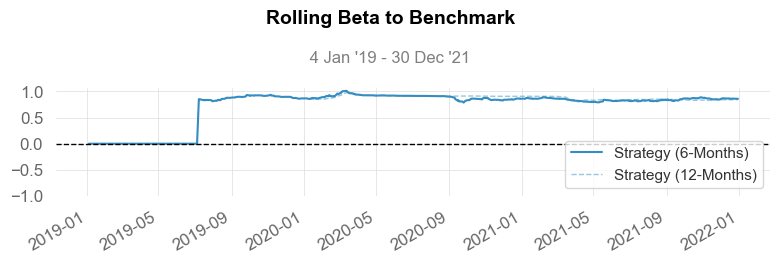

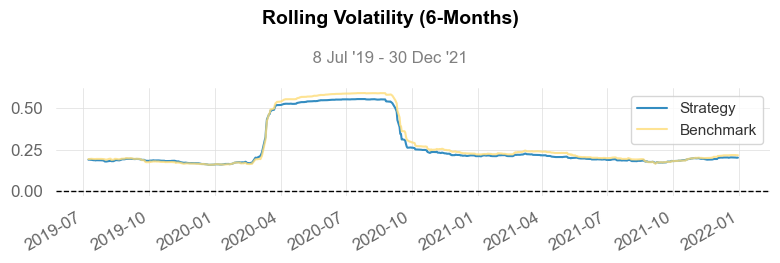

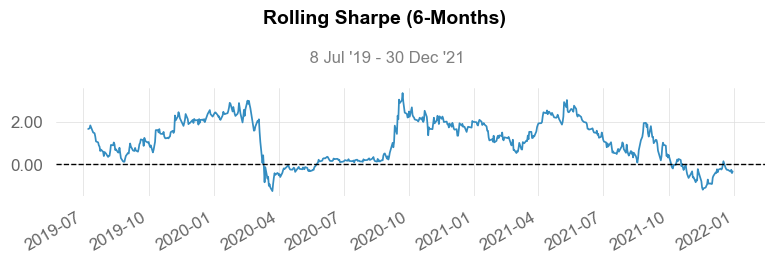

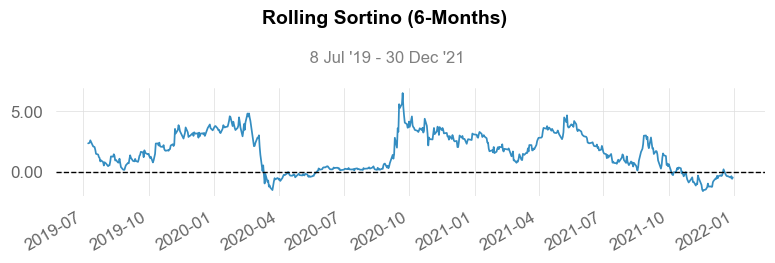

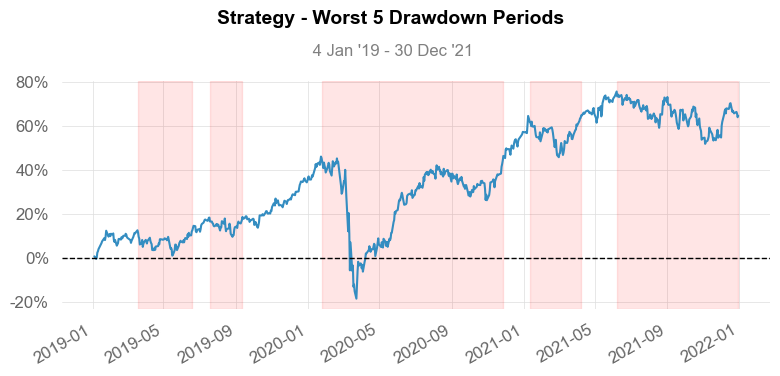

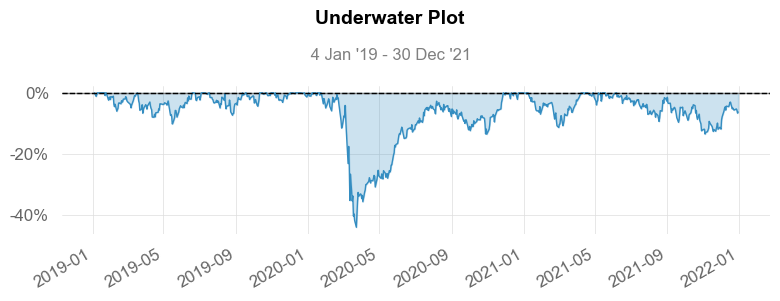

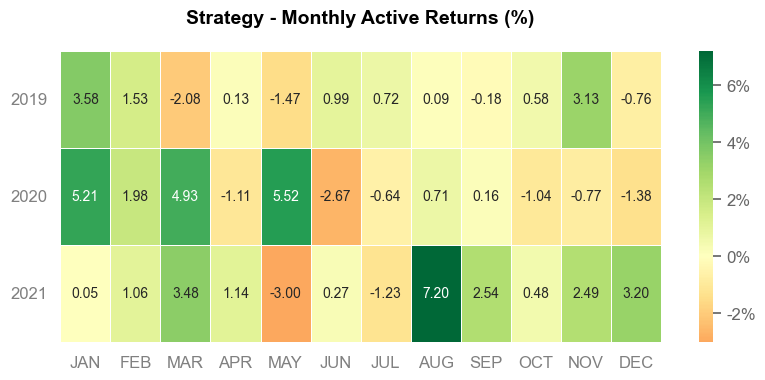

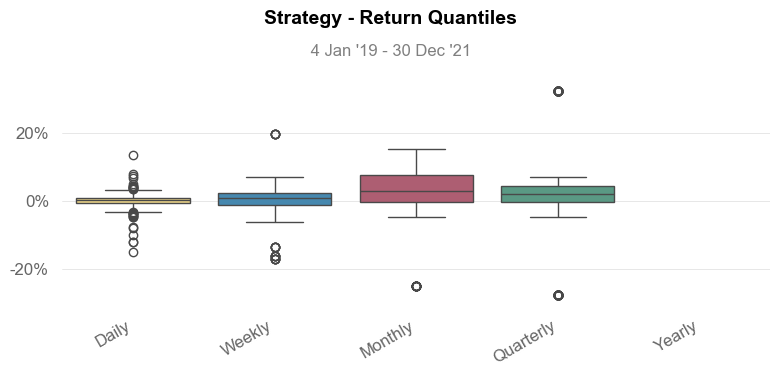

In [163]:
qs.reports.full(df_train.pct_change().mean(axis=1).dropna(), benchmark='^BVSP')

In [164]:
import bt
from ffn.utils import clean_ticker

In [165]:
data = bt.get(','.join(symbols), start='2019-01-01')

In [166]:
benchmark_data = bt.get('^BVSP', start='2019-01-01')

In [167]:
clean_ticker_weights = {clean_ticker(ticker): weight for ticker, weight in cleaned_weights.items()}

<Axes: title={'center': 'Equity Progression'}>

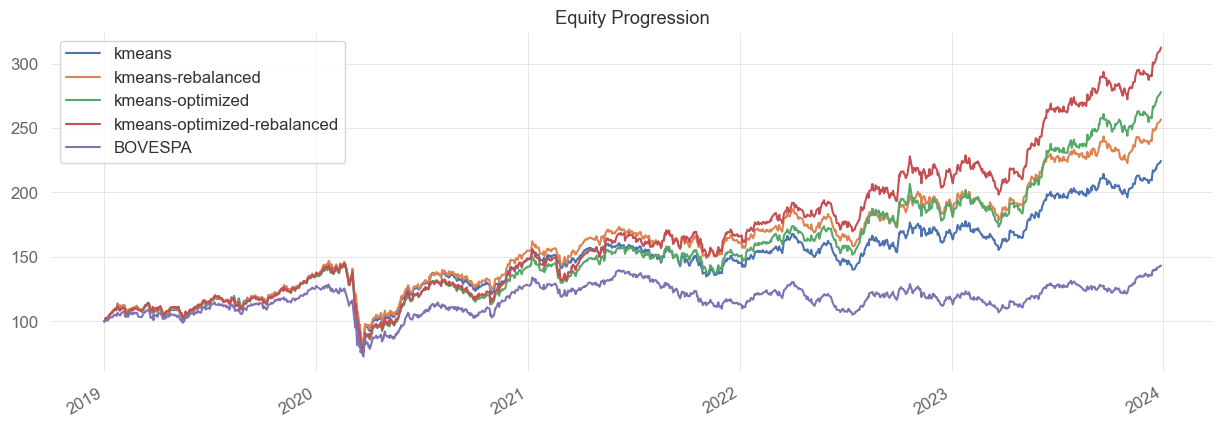

In [170]:
s1 = bt.Strategy('kmeans', [bt.algos.RunOnce(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighEqually(),
                       bt.algos.Rebalance()])

s2 = bt.Strategy('kmeans-rebalanced', [bt.algos.RunMonthly(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighEqually(),
                       bt.algos.Rebalance()])

s3 = bt.Strategy('kmeans-optimized', [bt.algos.RunOnce(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighSpecified(**clean_ticker_weights),
                       bt.algos.Rebalance()])


s4 = bt.Strategy('kmeans-optimized-rebalanced', [bt.algos.RunMonthly(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighSpecified(**clean_ticker_weights),
                       bt.algos.Rebalance()])

benchmark = bt.Strategy('BOVESPA', [bt.algos.RunOnce(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighEqually(),
                       bt.algos.Rebalance()])


bt.run(bt.Backtest(s1, data), bt.Backtest(s2, data), bt.Backtest(s3, data), bt.Backtest(s4, data), bt.Backtest(benchmark, benchmark_data)).plot()